Primero cargamos los datos que ya hemos procesado con PCA. (hemos caracterizado audios en una dimensionalidad mas baja)

In [34]:
#cargar librerias y datos

#lo basico
import numpy as np 
import matplotlib.pyplot as plt
import scipy
import pandas as pd


#clustering
from sklearn.cluster import KMeans, MeanShift, DBSCAN
from sklearn_extra.cluster import KMedoids

#supervisado
from sklearn.tree import DecisionTreeClassifier ,plot_tree
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC,LinearSVC

#crossval y parameter estimation
from sklearn.model_selection import KFold,cross_validate, train_test_split, cross_val_score, \
                                    GridSearchCV

#metricas y preprocesado y tal
from sklearn.preprocessing import StandardScaler,MinMaxScaler,MaxAbsScaler
from sklearn.metrics import confusion_matrix, accuracy_score,roc_auc_score,cohen_kappa_score,f1_score, \
                            precision_score,recall_score,make_scorer


#miscelanea
from sklearn.utils import shuffle


In [2]:
#carga de los datos ya seleccionados mediante un algoritmo PCA
X=np.load("datos_mfcc_pca99_X.npy")
y=np.load("datos_mfcc_pca99_y.npy")

# Algoritmos de clustering

Primero intento los algoritmos clasicos de clustering:  



Luego como veremos, no dan muy buenos resultados en la agrupacion de clases, esto puede explicarse en parte por la alta dimensionalidad que tiene el espacio en el que estamos realizando las agrupaciones, y quizá considerando menos dimensiones (las más importantes o relevantes), o haciendo una segund reduccion de la dimensionalidad, así seamos capaces de que ls algoritmos de clustering logren algo.


# Algoritmos supervisados  
Para esta tarea se nos indica que realizemos una selección de 50% pero ateníendonos a que sean representantes de cada uno de los grupos. Esto es muy indicado sobretodo para el caso de los métodos kernel, pues los datos de entrenamiento serán usados para calcular similitudes y nos gustaría que estos fueran lo más represetantes de su clase como fuera posible.  
Vamos a buscar con k-means tantos representantes en una clase como queramos.  

In [54]:
#vamos a ir guardando en un dataframe los resultados que obtenemos de los diferentes algoritmos
resultados=pd.DataFrame(columns=["Algoritmo","Using_reduction","Accuracy_train","Accuracy_test",
                                 "Accuracy_kfold","Precision_test","Precision_kfold","Recall_test","Recall_kfold",
                                 "cohen-kappa_train","cohen-kappa_test",
                                 "f1_test","f1_kfold","roc-auc_test"])

In [76]:
def train_and_get_stats(model,X,y,X_train,y_train,X_test,y_test,cv=5,train=False):
    #vamos a hacer una funcion que nos reciba el modelo, los datos y algunos parametros más, y nos evalue todo esto
    #asi nos lo devuelve y ya lo tenemos para meterlo en el dataframe

    #esta funcion va a tomar el modelo, lo va a entrenar y va a darnos las metricas,
    #pero no va a hacer nada sobre la busqueda de parametros optimos
    
    
    #calculamos en train y test de forma normal con los conjuntos train y test
    if train:
        model.fit(X_train,y_train)
    y_pred_train=model.predict(X_train)
    y_pred_test=model.predict(X_test)
    
    #calculamos las metricas que nos hacen falta
    aux1=pd.Series({"Accuracy_train":accuracy_score(y_train,y_pred_train),
                      "Accuracy_test":accuracy_score(y_test,y_pred_test),
                      "Precision_test":precision_score(y_test,y_pred_test,average="micro"),
                      "Recall_test":recall_score(y_test,y_pred_test,average="micro"),
                      "cohen-kappa_train":cohen_kappa_score(y_train,y_pred_train),
                      "cohen-kappa_test":cohen_kappa_score(y_test,y_pred_test),
                      "f1_test":f1_score(y_test,y_pred_test,average="micro")})
                      #"roc-auc_test":roc_auc_score(y_test,y_pred_test)})

    
    #Tambien vamos a usar cross validation para obtener una estimacion más correcta de los parametros
    prec = make_scorer(precision_score,greater_is_better=True, average="micro")
    recall = make_scorer(recall_score,greater_is_better=True, average="micro")
    f1 = make_scorer(f1_score,greater_is_better=True, average="micro")


    metrics_aux=cross_validate(model, X,y,cv=cv,
                               scoring={"accuracy":"accuracy","precision":prec,
                                        "recall":recall,"f1":f1},
                               return_train_score=False)
    #obtenemos un diccionario y listas de las estadisticas para cada una de las evaluaciones en los k folds
    #ahora para guardarlos hacemos la media de estas
    
    aux2=pd.Series({"Accuracy_kfold":np.mean(metrics_aux["test_accuracy"]),
                                "Precision_kfold":np.mean(metrics_aux["test_precision"]),
                                "Recall_kfold":np.mean(metrics_aux["test_recall"]),
                                "f1_kfold":np.mean(metrics_aux["test_f1"])})

    return pd.concat([aux1,aux2])

    
#def optimal_params_completa():
    #esta funcion usará una lista de parametros para hacer mediante grid search una busqueda de
    #los mejores parametros
    
    #la estrategia para la busqueda de hyperparametros será una búsqueda inicial mediante 
    #una busqueda aleatoria y una consecuente busqueda en grid por los mejores valores anteriores, 
    #donde ya apuntamos un poco más
    
    
    

    
    

In [6]:
#hacemos el conjunto de datos reducido donde solo seleccionamos el 50% de los puntos como
#representantes del conjunto 

clases=np.unique(y).shape[0]

X_reduc=[]
y_reduc=[]

for i in range(clases):
    len_aux=len(y[y==i])
    model=KMedoids(n_clusters=len_aux//2)
    model.fit(X[y==i])  
    centros=model.cluster_centers_
    X_reduc.append(centros)
    y_reduc.extend(np.ones(len(centros))*i)
X_reduc=np.array(X_reduc)
y_reduc=np.array(y_reduc)
X_reduc2=X_reduc.reshape(-1,464)

In [7]:
y_reduc.shape

(360,)

In [8]:
#separamos los datos en conjuntos para entrenamiento y para test
#lo hacemos tanto para el conjunto completo como  para el reducido por representantes
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
X_reduc_train,X_reduc_test,y_reduc_train,y_reduc_test=train_test_split(X_reduc2,y_reduc,
                                                                       test_size=0.2,random_state=42)

In [9]:
#hacemos shuffle a los datos originales por si los quisieramos usar mas adelante 
X,y=shuffle(X,y,random_state=42)

### Preprocesamos los datos para normalizarlos o algo? 

Standar Scaler??

### Arboles

No veo motivo para limitar aqui el conjunto de entrenamiento, pero vamos a probar con lo dos.  

También podemos hacer pre-prunning (lo normal), y post-prunning



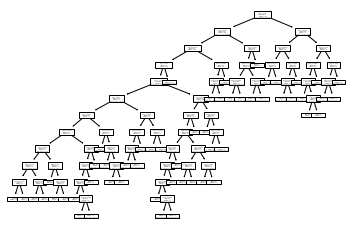

In [151]:

model1=DecisionTreeClassifier()
model1.fit(X_train,y_train)
plot_tree(model1);

In [152]:
y_pred=model1.predict(X_test)
confusion_matrix(y_test,y_pred)


array([[ 6,  1,  1,  2,  3,  2],
       [ 0,  9,  2,  1,  2,  4],
       [ 5,  2,  7,  5,  0,  2],
       [ 1,  5,  5,  8,  1,  0],
       [ 0,  1,  1,  2, 10,  0],
       [ 4,  5,  0,  2,  4,  5]])

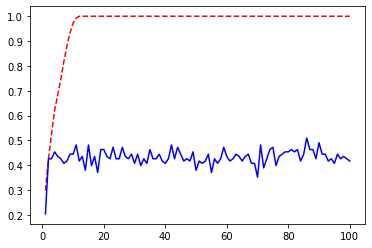

In [153]:
#ahroa vamos a probar a hacerle el post-prunning
acc_train_list=[]
acc_test_list=[]
depths=list(range(1,101))
for i in depths:
    model=DecisionTreeClassifier(max_depth=i)
    model.fit(X_train,y_train)
    y_pred_1=model.predict(X_train)
    acc_train_list.append(accuracy_score(y_train,y_pred_1))
    y_pred_2=model.predict(X_test)
    acc_test_list.append(accuracy_score(y_test,y_pred_2))


plt.plot(depths,acc_train_list,"r--")
plt.plot(depths,acc_test_list,"b")

In [154]:
model=DecisionTreeClassifier(max_depth=100)
aux=model.cost_complexity_pruning_path(X_train,y_train)
ccp,imps=aux.ccp_alphas, aux.impurities

In [155]:

acc_train_list_pruned=[]
acc_test_list_pruned=[]
node_counts=[]
for i in ccp:
    model=DecisionTreeClassifier(ccp_alpha=i)
    model.fit(X_train,y_train)
    y_pred_1=model.predict(X_train)
    node_counts.append(model.get_depth())
    acc_train_list_pruned.append(accuracy_score(y_train,y_pred_1))
    y_pred_2=model.predict(X_test)

    acc_test_list_pruned.append(accuracy_score(y_test,y_pred_2))


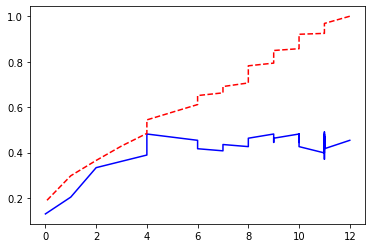

In [156]:
plt.plot(node_counts,acc_test_list_pruned,"b")
plt.plot(node_counts,acc_train_list_pruned,"r--")

Podemos probar con solo los puntos representativos de los clusteres, pero eso no da mejores resultado, ya lo he intentado.

### Random forest

In [166]:
model=RandomForestClassifier(1000,max_depth=7)
model.fit(X_train,y_train)

RandomForestClassifier(max_depth=7, n_estimators=1000)

In [167]:
y_pred1=model.predict(X_train)
y_pred2=model.predict(X_test)
print(accuracy_score(y_train,y_pred1),accuracy_score(y_test,y_pred2))

0.9484126984126984 0.6157407407407407


In [180]:
model=RandomForestClassifier(1000,max_depth=7)
a=cross_validate(model,X,y,scoring=["accuracy"],cv=5)

In [189]:
a["test_accuracy"].mean()

0.6555555555555556

Aqui podriamos hacer gridsearch y tal

### Redes neuronales

In [209]:

model=MLPClassifier(hidden_layer_sizes=[100,10],learning_rate="adaptive",learning_rate_init=0.004,max_iter=1000)
aux=cross_validate(model,X,y,scoring=["accuracy"],cv=5,return_train_score=True)
aux

{'fit_time': array([1.03077722, 1.1708622 , 0.98245239, 1.63729954, 0.87973714]),
 'score_time': array([0.00079393, 0.00080156, 0.00078583, 0.00085974, 0.00077128]),
 'test_accuracy': array([0.52083333, 0.54166667, 0.50694444, 0.50694444, 0.47916667]),
 'train_accuracy': array([0.96180556, 0.93923611, 0.98263889, 0.87673611, 0.96701389])}

### SVM

In [231]:
#a=MinMaxScaler()
#X_norm=a.fit_transform(X)


model=SVC()
aux=cross_validate(model,X_reduc2,y_reduc,scoring=["accuracy"],cv=5,return_train_score=True)
aux

{'fit_time': array([0.02615619, 0.01765418, 0.01693678, 0.01718783, 0.01654029]),
 'score_time': array([0.01315546, 0.00729942, 0.00710082, 0.00712657, 0.00719333]),
 'test_accuracy': array([0.56944444, 0.58333333, 0.625     , 0.56944444, 0.52777778]),
 'train_accuracy': array([0.8125    , 0.79513889, 0.78472222, 0.8125    , 0.80208333])}

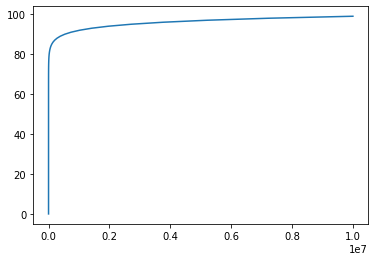

In [240]:
n=100
plt.plot(np.logspace(-7,7,n),list(range(n)))

## Busqueda iterativa de los mejores modelos etc

In [47]:
#para arboles

#gridserach
tree_params={"criterion":["gini","entropy"],"max_depth":np.arange(2,50,4)}

#lo evaluamos 

model_tree=DecisionTreeClassifier()

tree_best=GridSearchCV(model_tree,tree_params)
tree_best.fit(X_train,y_train)



GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([ 2,  6, 10, 14, 18, 22, 26, 30, 34, 38, 42, 46])})

In [48]:
print(tree_best.best_score_, tree_best.best_params_)

0.4808395802098951 {'criterion': 'entropy', 'max_depth': 6}


In [52]:
#para random forests

#grid

forest_params={"n_estimators":np.arange(40,100,2000),"criterion":["gini","entropy"],"max_depth":[2,3,5,10,30]}

model_forest=RandomForestClassifier()
forest_best=GridSearchCV(model_forest,forest_params)
forest_best.fit(X_train,y_train)



GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 30],
                         'n_estimators': array([40])})

In [53]:
print(forest_best.best_score_, forest_best.best_params_)

0.5329385307346326 {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 40}


In [64]:
#para bagging

bagging_params={"base_estimator":[MLPClassifier(40),SVC(),DecisionTreeClassifier()],"n_estimators":[40,60]}
model_bagging=BaggingClassifier()
bagging_best=GridSearchCV(model_bagging,bagging_params)
bagging_best.fit(X_reduc_train,y_reduc_train)



GridSearchCV(estimator=BaggingClassifier(),
             param_grid={'base_estimator': [MLPClassifier(hidden_layer_sizes=40),
                                            SVC(), DecisionTreeClassifier()],
                         'n_estimators': [10, 40]})

In [67]:
print(bagging_best.best_score_, bagging_best.best_params_)

0.621113127646703 {'base_estimator': SVC(), 'n_estimators': 40}


In [59]:
#para SVM

svm_params={"C":np.linspace(0.1,2,20),"kernel":["rbf","poly"],"degree":[2,3,4,5]}


model_svm=SVC()
svm_best=GridSearchCV(model_svm,svm_params)
svm_best.fit(X_reduc_train,y_reduc_train)


GridSearchCV(estimator=SVC(),
             param_grid={'C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]),
                         'degree': [2, 3, 4, 5], 'kernel': ['rbf', 'poly']})

In [60]:
print(svm_best.best_score_, svm_best.best_params_)

0.6141560798548095 {'C': 1.5, 'degree': 2, 'kernel': 'rbf'}


In [45]:
#AdaBoost

ada_params={"base_estimator":[SVC(),DecisionTreeClassifier()],
                 "n_estimators":[50,70,100,140],"learning_rate":np.logspace(0.4,5,10)}


model_ada=AdaBoostClassifier()
ada_best=GridSearchCV(model_ada,ada_params)
ada_best.fit(X_reduc_train,y_reduc_train)



/home/arturo/anaconda3/envs/env1/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
200 fits failed out of a total of 400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "/home/arturo/anaconda3/envs/env1/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/arturo/anaconda3/envs/env1/lib/python3.8/site-packages/sklearn/ensemble/_weight_boosting.py", line 486, in fit
    return super().fit(X, y, sample_weight)
  File "/home/arturo/anaconda3/envs/env1/lib/python3.8/site-packages/sklearn/ensemble/_weight_boosting

GridSearchCV(estimator=AdaBoostClassifier(),
             param_grid={'base_estimator': [SVC(), DecisionTreeClassifier()],
                         'learning_rate': array([2.51188643e+00, 8.14912747e+00, 2.64376119e+01, 8.57695899e+01,
       2.78255940e+02, 9.02725178e+02, 2.92864456e+03, 9.50118507e+03,
       3.08239924e+04, 1.00000000e+05]),
                         'n_estimators': [50, 70, 100, 140]})

In [ ]:
print(ada_best.best_score_, ada_best.best_params_)

In [39]:
#NNs

mlp_params={"hidden_layer_sizes":[(100,20),(100),(20,20),(10),(20,20,20)],
            "learning_rate":["constant","adaptative"],"learning_rate_init":[0.001,0.005,0.0001,0.04]}


model_mlp=MLPClassifier(max_iter=500)
mlp_best=GridSearchCV(model_mlp,mlp_params)
mlp_best.fit(X_train,y_train)


/home/arturo/anaconda3/envs/env1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/arturo/anaconda3/envs/env1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/arturo/anaconda3/envs/env1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/arturo/anaconda3/envs/env1/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


GridSearchCV(estimator=MLPClassifier(max_iter=500),
             param_grid={'hidden_layer_sizes': [(100, 20), 100, (20, 20), 10,
                                                (20, 20, 20)],
                         'learning_rate': ['constant', 'adaptative'],
                         'learning_rate_init': [0.001, 0.005, 0.0001, 0.04]})

In [66]:
print(mlp_best.best_score_, mlp_best.best_params_)

0.5537481259370315 {'hidden_layer_sizes': 100, 'learning_rate': 'constant', 'learning_rate_init': 0.005}


Ahora hacemos una tabla resumen de los resultados:

In [69]:
a=svm_best.best_estimator_

In [84]:
resultados=pd.DataFrame(columns=["Algoritmo","Using_reduction","best_params","Accuracy_train","Accuracy_test",
                                 "Accuracy_kfold","Precision_test","Precision_kfold","Recall_test","Recall_kfold",
                                 "cohen-kappa_train","cohen-kappa_test",
                                 "f1_test","f1_kfold"])
names=["Tree","SVC","Forest","MLP","Adaboost","Bagging"]
reduction_list=["F","T","F","F","T","T"]

for i,j in enumerate([tree_best,svm_best,forest_best,
                    mlp_best,ada_best,bagging_best]):
    aux_series=train_and_get_stats(j.best_estimator_,X,y,X_train,y_train,X_test,y_test,cv=5)
    aux_series=aux_series.append(pd.Series({"Algoritmo":names[i],"Using_reduction":reduction_list[i],
                                            "best_params":j.best_params_}))
    resultados=resultados.append(aux_series,ignore_index=True)

In [85]:
resultados

,Algoritmo,Using_reduction,best_params,Accuracy_train,Accuracy_test,Accuracy_kfold,Precision_test,Precision_kfold,Recall_test,Recall_kfold,cohen-kappa_train,cohen-kappa_test,f1_test,f1_kfold
0,Tree,F,"{'criterion': 'entropy', 'max_depth': 6}",0.746528,0.479167,0.463889,0.479167,0.463889,0.479167,0.463889,0.695374,0.380236,0.479167,0.463889
1,SVC,T,"{'C': 1.5, 'degree': 2, 'kernel': 'rbf'}",0.600694,0.659722,0.684722,0.659722,0.684722,0.659722,0.684722,0.520620,0.591265,0.659722,0.684722
2,Forest,F,"{'criterion': 'gini', 'max_depth': 5, 'n_estim...",0.871528,0.583333,0.558333,0.583333,0.558333,0.583333,0.558333,0.845542,0.504474,0.583333,0.558333
3,MLP,F,"{'hidden_layer_sizes': 100, 'learning_rate': '...",1.000000,0.597222,0.561111,0.597222,0.561111,0.597222,0.561111,1.000000,0.518700,0.597222,0.561111
4,Adaboost,T,"{'base_estimator': DecisionTreeClassifier(), '...",1.000000,0.465278,0.461111,0.465278,0.461111,0.465278,0.461111,1.000000,0.358333,0.465278,0.461111
5,Bagging,T,"{'base_estimator': SVC(), 'n_estimators': 40}",0.559028,0.652778,0.680556,0.652778,0.680556,0.652778,0.680556,0.470531,0.582778,0.652778,0.680556
